**TFM - Latent space comparison between different generative models (VAE, GAN, StyleGAN...)**

In [15]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import cv2
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
from tqdm import tqdm

torch.manual_seed(0);
# Set random seed for reproducibility
random.seed(0)

------------------------------------------
**GAN Discriminator and Generator architecture**

### Network

In [16]:
# Custom weights initialization for both Generator and Discriminator networks
def weights_init(m):
    classname = m.__class__.__name__
    # If the layer is a convolutional layer, initialize weights with a normal distribution
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    # If the layer is a batch normalization layer, initialize weights and biases
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Generator class definition
class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
       
        # Main architecture of the generator: series of transpose convolutions to upsample
        self.main = nn.Sequential(
            # Input: latent vector Z, shape [nz, 1, 1], going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8,  kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Output shape: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4,  kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Output shape: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1,output_padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Output shape: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # Final output: grayscale image (nc channels), shape: nc x 32 x 32
            nn.ConvTranspose2d(ngf, nc, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh() # Output pixel values normalized between -1 and 1
        )

    def forward(self, input):
        # Forward pass through the generator network
        return self.main(input)
       
# Discriminator class definition
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        
        # Main architecture of the discriminator: series of convolutions to downsample
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf * 4,kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*4, ndf * 4,kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer: binary classification for real/fake, shape: (1) x 1 x 1
            nn.Conv2d(ndf * 4, nc, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()    # Output between 0 and 1 (real or fake)
        )

    def forward(self, input):
        output = self.main(input)
        # Flatten the output to match the real/fake label dimension
        return output.view(-1, 1).squeeze(1)

#### Dades

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (e.g., convert to tensor)
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST training and validation datasets
train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=True)

# DataLoader for training and validation
data_loader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
data_loader_val = DataLoader(test_dataset, batch_size=64, shuffle=False)

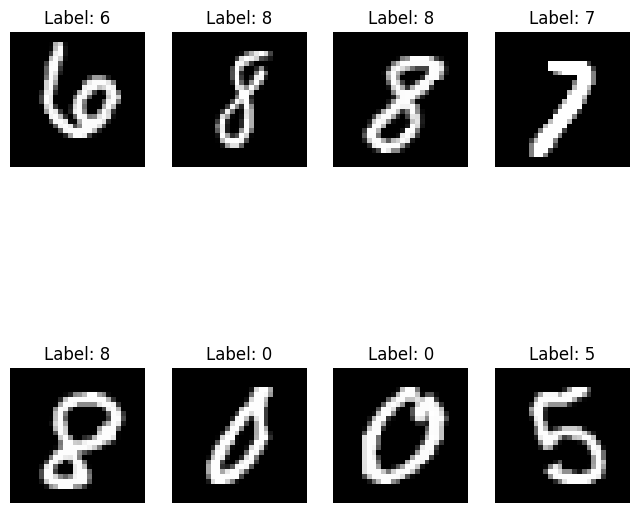

In [18]:
import matplotlib.pyplot as plt

# Get a batch of training data
images, labels = next(iter(data_loader_train))

# Plot the first few images in the batch
plt.figure(figsize=(8, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()


In [19]:
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 60000
Test set size: 10000


In [11]:
# Check the transformations applied on the first sample
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

image, label = train_dataset[0]
print(f"Image after normalization: Min value {image.min()}, Max value {image.max()}")


Image after normalization: Min value 0.0, Max value 1.0


In [20]:
# Inspect a batch of data from the train loader
data_iter = iter(data_loader_train)
images, labels = next(data_iter)  # Use the global next() function

print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")
print(f"Data type: {images.dtype}")

# Example: Check the pixel value range (normalized or raw)
print(f"Min pixel value: {images.min().item()}, Max pixel value: {images.max().item()}")


Batch of images shape: torch.Size([64, 1, 28, 28])
Batch of labels shape: torch.Size([64])
Data type: torch.float32
Min pixel value: 0.0, Max pixel value: 1.0


### Entrenament

#### Paràmetres d'entrenament

In [21]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GAN training parameters
ld = 2  # Latent space dimension
ngf = 64  # Number of generator filters
ndf = 64  # Number of discriminator filters
num_epochs = 10  # Number of training epochs

In [25]:
nz = 2
# Initialize Generator and Discriminator networks
netG = Generator(nz=ld).to(device)
netG.apply(weights_init)
#netG.load_state_dict(torch.load('my_nets/netG_epoch_99.pth'))

netD = Discriminator().to(device)
netD.apply(weights_init)
#netD.load_state_dict(torch.load('my_nets/netD_epoch_99.pth'))

# Loss function for GAN (Binary Cross-Entropy)
criterion = nn.BCELoss()

# Optimizers for both networks
batch_size = 64 #Hauría de ser consistent amb el batch size de les dades
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

losses = np.zeros(num_epochs)
losses_val = np.zeros(num_epochs)

# Initialize lists to store the losses
G_losses = []
D_losses = []

# Training loop
pbar = tqdm(range(1, num_epochs+1)) # Progress bar for tracking progress
for epoch in pbar:
    for i, (data, _) in enumerate(data_loader_train, 0):
        ############################
        # Step 1: Train Discriminator with real and fake data
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad() 
        data = data.to(device)
        batch_size = data.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float,device=device)

        # Forward pass real batch through Discriminator
        output = netD(data)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images using the Generator
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        # Forward pass fake batch through Discriminator
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step() # Update Discriminator weights

        ############################
        # Step 2: Train Generator to fool the Discriminator
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) # Real labels for generator
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step() # Update Generator weights

        # Store the losses after each update
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        
        pbar.set_description('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch, num_epochs, i, len(data_loader_train),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        #if i % 100 == 0:
        #    vutils.save_image(real_cpu,'output/real_samples.png' ,normalize=True)
        #    fake = netG(fixed_noise)
        #    vutils.save_image(fake.detach(),'output/fake_samples_epoch_%03d.png' % (epoch), normalize=True)        
    
    #torch.save(netG.state_dict(), 'weights/netG_epoch_%d.pth' % (epoch))
    #torch.save(netD.state_dict(), 'weights/netD_epoch_%d.pth' % (epoch))

[10/10][937/938] Loss_D: 0.0000 Loss_G: 14.9001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000: 100%|██████████| 10/10 [02:55<00:00, 17.57s/it]


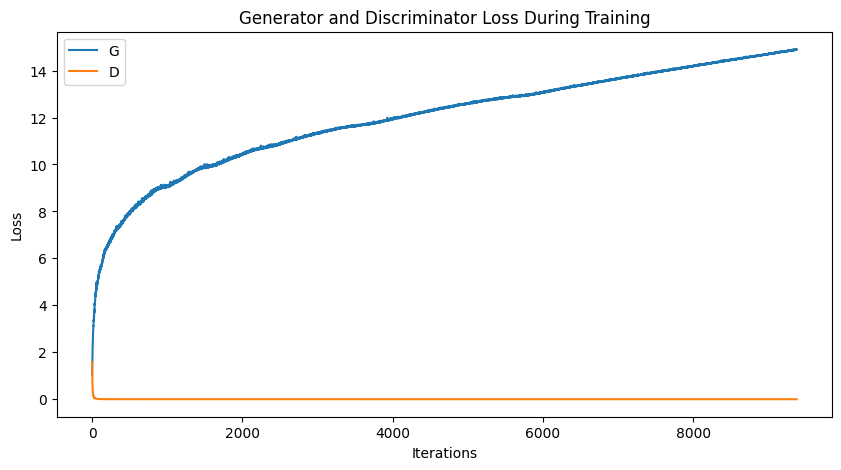

In [26]:
# After training, plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generació de dades

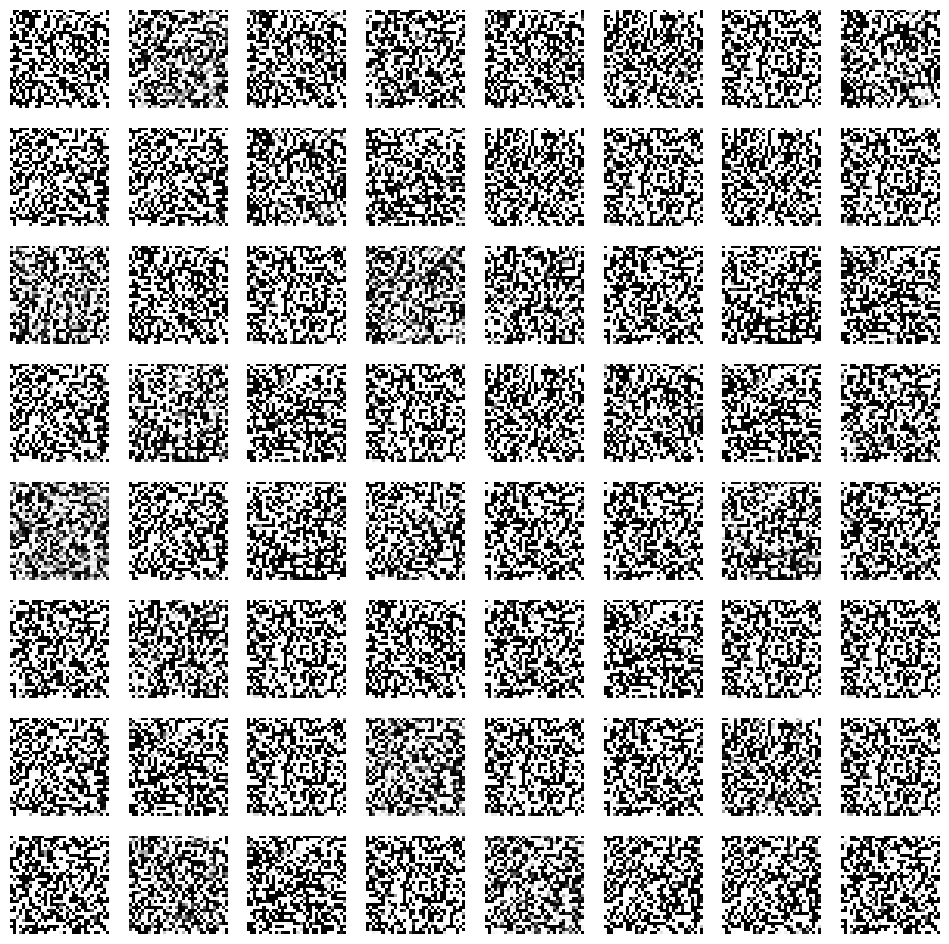

In [27]:
latent_size = ld
batch_size = 64
fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
    
fake_images = netG(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()

fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 32, 32)
R, C = 8, 8

fig = plt.figure(figsize=(12, 12))

for i in range(batch_size):
  
    axes = fig.add_subplot(R, C, i+1)
    axes.imshow(fake_images_np[i], cmap='gray');
    axes.set_axis_off()

plt.show();

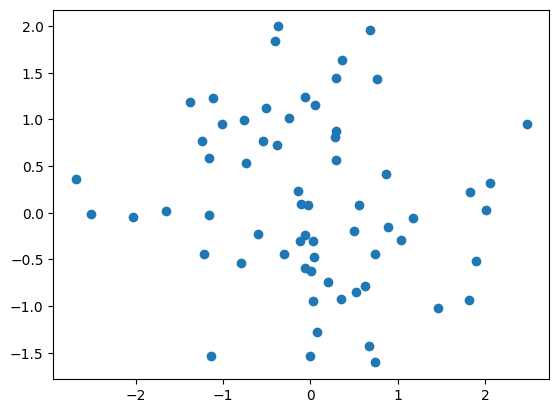

In [28]:
plt.scatter(fixed_noise[:,0,:,:].cpu(),fixed_noise[:,1,:,:].cpu());

### Projectam l'espai

In [32]:
myspace = [(x, y) for x in np.linspace(-3, 4, 20) for y in np.linspace(-3, 4,20)]
myspace = torch.tensor(myspace, dtype=torch.float32)
data_loader_myspace = torch.utils.data.DataLoader(list(zip(myspace, [11]*len(myspace))), batch_size=400, shuffle=False)
len(myspace)
#x.shape

400

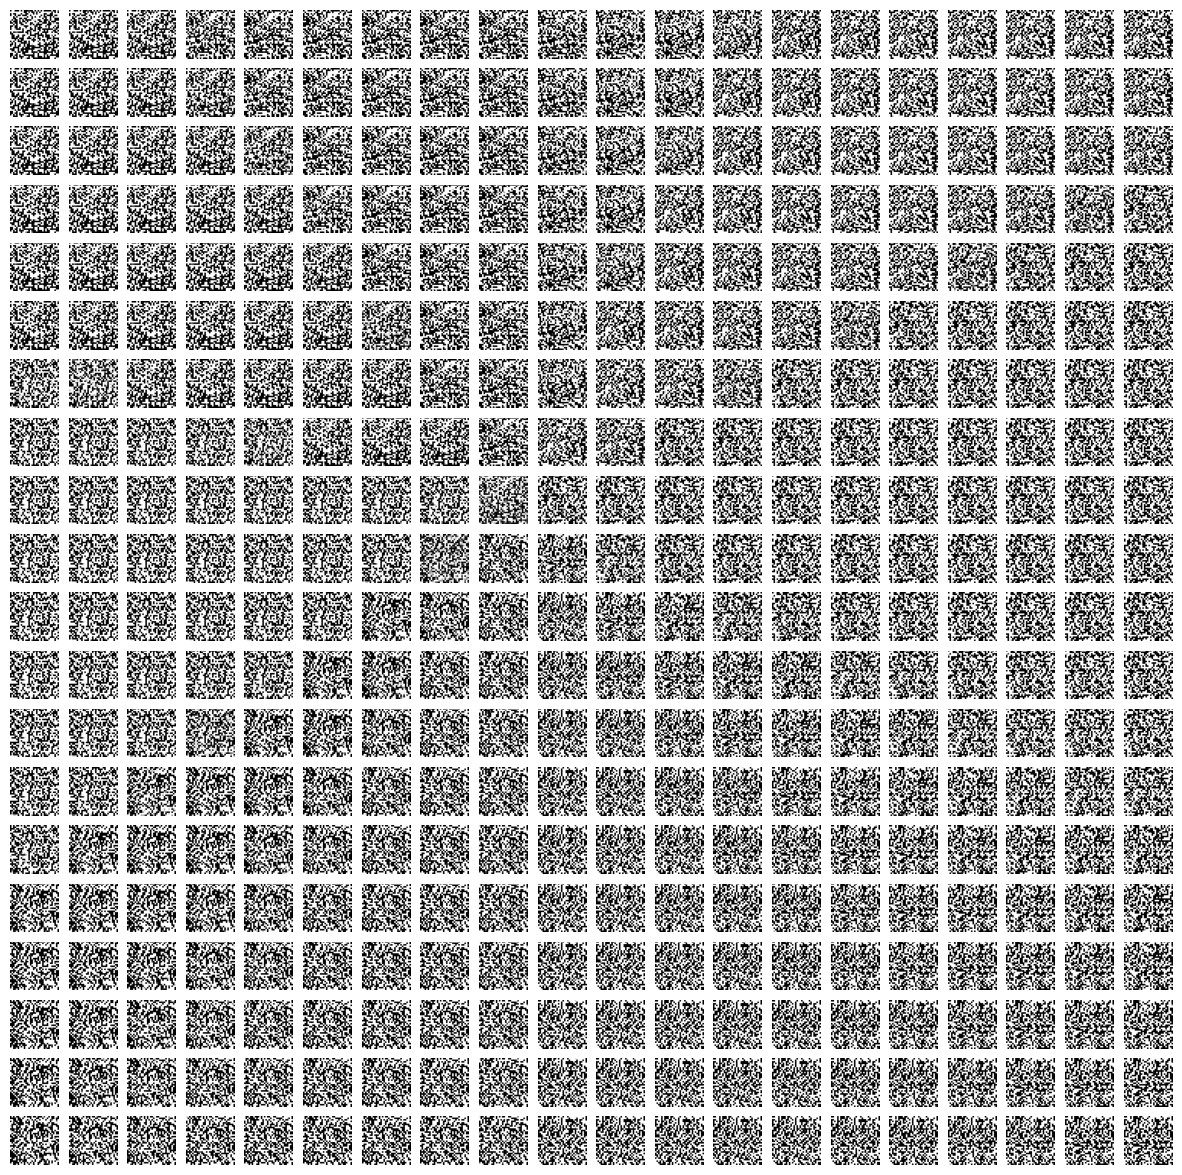

In [33]:
netG.eval()
fig = plt.figure(figsize=(15, 15))

for data in data_loader_myspace:
    # Forward pass
    x, label = data
    x = x.to(device)
    xx = torch.randn(400, nz, 1, 1, device=device)
    xx[:,:,0,0] = x 
    fake = netG(xx)
    for i in range(len(fake[:,0,:,:])):
        axes = fig.add_subplot(20,20, i+1)
        axes.imshow(fake[i,0,:,:].detach().cpu().numpy(), cmap='gray');
        axes.set_axis_off()

plt.show()